# (실습) Image Classification 실습

## 실습 개요
1) **실습 목적**

- 이번 실습에서는 Image Classification에서 사용하는 대표적인 모델인 EfficientNet을 이용하여 입력 이미지마다 어떤 출력값을 가지게 되는지를 직접 확인해봅니다. 개별 이미지와 여러 이미지 단위로 Image Classification 실습을 수행하며, Image Classification에 대해 이해합니다. 평가 Metric을 이용해 모델의 성능을 측정하는 과정을 수행합니다.

2) **수강 목표**

- Image Classification 모델을 라이브러리를 이용해 모델을 불러올 수 있다.
- Image Classification 모델을 개별 이미지 단위로 추론할 수 있다.
- Image Classification 모델을 여러 장의 이미지에 대해서 추론 및 평가할 수 있다.


### 실습 목차
* 1. 개별 이미지를 이용한 Image Classifcation 추론
  * 1.1 데이터 불러오기
  * 1.2 데이터 전처리하기
  * 1.3 싱글 이미지 추론하기

* 2. 여러 장의 이미지를 이용한 Image Classifcation 추론
  * 2.1 데이터 불러오기
  * 2.2 배치 이미지 추론하기
  * 2.3 성능 지표 계산하기


### 환경 설정

- 패키지 설치 및 임포트

In [ ]:
!pip3 install torch==2.0.1
!pip3 install validators

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # python 경고 무시

import torch # PyTorch 라이브러리

import torchvision # PyTorch의 컴퓨터 비전 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈
import torchvision.utils as vutils # 이미지를 쉽게 처리하기 위한 유틸리티 모듈

from PIL import Image # 이미지 처리를 위한 라이브러리
import json # json 파일을 다루기 위한 라이브러리

import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
import requests  # URL 접근을 위한 라이브러리
import os # 여러 운여체제에서 지원하는 커맨드를 파이썬에서 호출하기 위한 라이브러리
import numpy as np # 다차원 배열 형태의 데이터를 다루기 위한 라이브러리

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # sklearn 내 confusion matrix 계산 함수

In [ ]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [ ]:
# 가속 환경을 설정해 줍니다
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

## 1. 개별 이미지를 이용한 Image Classifcation 추론

```
💡 목차 개요: Torch Hub 라이브러리를 이용해 Image Classification 모델을 불러오고 개별 이미지 단위로 추론할 수 있다.
```

- 1.1 이미지 불러오기
- 1.2 이미지 전처리하기
- 1.3 싱글 이미지 추론하기

### 1.1 이미지 불러오기

> 추론할 이미지 및 레이블 데이터를 불러옵니다.

#### 클래스 목록 불러오기

클래스(레이블) 목록을 불러옵니다. 여기서는 ImageNet 클래스 목록을 가져옵니다.

In [ ]:
# 클래스 목록 불러오기
!wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt

--2023-11-05 08:50:22--  https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31565 (31K) [text/plain]
Saving to: ‘labels_map.txt’

labels_map.txt      100%[===================>]  30.83K  --.-KB/s    in 0.007s  

2023-11-05 08:50:23 (4.53 MB/s) - ‘labels_map.txt’ saved [31565/31565]



In [ ]:
# 클래스 목록 불러오기
labels_map = json.load(open('labels_map.txt'))
labels_map

{'0': 'tench, Tinca tinca',
 '1': 'goldfish, Carassius auratus',
 '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 '3': 'tiger shark, Galeocerdo cuvieri',
 '4': 'hammerhead, hammerhead shark',
 '5': 'electric ray, crampfish, numbfish, torpedo',
 '6': 'stingray',
 '7': 'cock',
 '8': 'hen',
 '9': 'ostrich, Struthio camelus',
 '10': 'brambling, Fringilla montifringilla',
 '11': 'goldfinch, Carduelis carduelis',
 '12': 'house finch, linnet, Carpodacus mexicanus',
 '13': 'junco, snowbird',
 '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 '15': 'robin, American robin, Turdus migratorius',
 '16': 'bulbul',
 '17': 'jay',
 '18': 'magpie',
 '19': 'chickadee',
 '20': 'water ouzel, dipper',
 '21': 'kite',
 '22': 'bald eagle, American eagle, Haliaeetus leucocephalus',
 '23': 'vulture',
 '24': 'great grey owl, great gray owl, Strix nebulosa',
 '25': 'European fire salamander, Salamandra salamandra',
 '26': 'common newt, Triturus vulga

#### 이미지 불러오기

강아지 이미지를 불러옵니다.

In [ ]:
# 강아지 이미지 불러오기
!wget https://raw.githubusercontent.com/BupyeongHealer/sample-image/3ae2ccdf8eb1238c68e35149d24e164d8b7e8a40/dog.jpg

--2023-11-05 08:50:23--  https://raw.githubusercontent.com/BupyeongHealer/sample-image/3ae2ccdf8eb1238c68e35149d24e164d8b7e8a40/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60067 (59K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  58.66K  --.-KB/s    in 0.009s  

2023-11-05 08:50:23 (6.26 MB/s) - ‘dog.jpg’ saved [60067/60067]



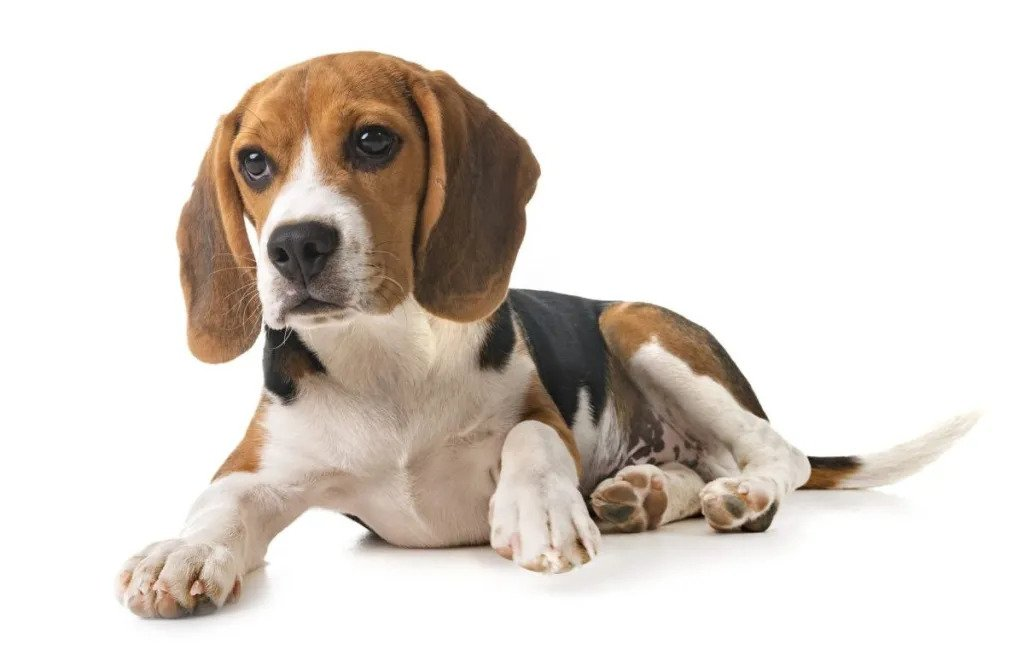

In [ ]:
# 강아지 이미지 보기
raw_img = Image.open('dog.jpg')
raw_img

### 1.2 이미지 전처리하기

> 사용할 상세 모델을 지정하고 이미지를 전처리합니다.

#### EfficientNet 모델 이용

EfficientNet 모델을 이용하기 위해 `torch.hub` 라이브러리를 이용합니다. 이 라이브러리를 이용해 추론에 사용할 상세 모델 이름을 지정하면 사전학습된 모델 가중치를 활용할 수 있습니다. 여기서 모델이 사전학습된 이미지 사이즈를 그대로 학습 및 추론해야 하므로 이를 우리의 이미지 사이즈로 지정합니다.

📚 참고할만한 자료:
* [Torch Hub](https://pytorch.org/hub/): Torch Hub는 PyTorch의 공식 확장 라이브러리로, 사전 훈련된 모델과 다른 리소스를 공유하고 검색하는 데 사용됩니다. 이 라이브러리를 통해 모델 아키텍처, 가중치, 텍스트 임베딩, 데이터셋 및 기타 관련 리소스를 손쉽게 다운로드하고 사용할 수 있습니다. Torch Hub를 통해 공유된 모델 및 리소스는 모델 경량화, 전이 학습, 및 기계 학습 실험을 용이하게 합니다.

#### 이미지 전처리하기

`torchvision` 라이브러리의 `transforms (T)` 내 함수로 이미지를 전처리합니다. 이에 필요한 변환을 정의하고 전처리합니다.

In [ ]:
# 이미지 전처리 시, 필요한 변환 정의
image_size = 224  # 모델이 사전학습된 이미지 사이즈를 그대로 학습 및 추론해야 함
img_transform = T.Compose([
    T.Resize(image_size), # 크기 변환
    T.CenterCrop(image_size), # 가운데 크롭
    T.ToTensor(), # 텐서 데이터 타입으로 변환
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize
])
img = img_transform(raw_img)
print('이미지 텐서 사이즈:', img.shape)
img = img.unsqueeze(0)  # 이미지 텐서를 배치 단위로 만들기: (3,224,224) -> (1,3,224,224)
print('변경한 이미지 텐서 사이즈:', img.shape)

이미지 텐서 사이즈: torch.Size([3, 224, 224])
변경한 이미지 텐서 사이즈: torch.Size([1, 3, 224, 224])


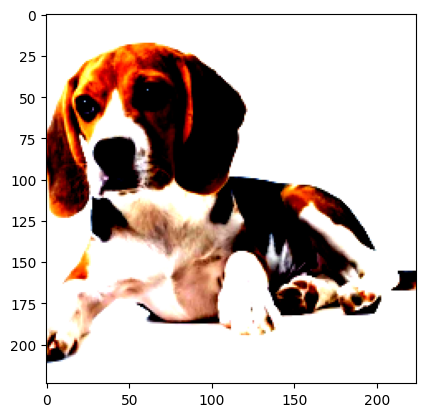

In [ ]:
# 전처리된 이미지 보기
plt.imshow(img.squeeze(0).permute(1,2,0))

### 1.3 싱글 이미지 추론하기

> Image Classification 모델 중 하나인 EfficientNet 모델을 이용한 Image Classification 태스크를 수행합니다.

EfficientNet-B0 모델을 불러오고, 해당 모델을 이용해 추론합니다.


<img src='https://github.com/BupyeongHealer/sample-image/blob/932ac0e060585c0dc4a4b98ef59bceb734302f33/efficientnet-b0.png?raw=true'>

In [ ]:
# EfficientNet 모델 불러오기
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model = model.to(device)
model

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 45.8MB/s]


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
# 모델 추론
model.eval()  # 모델을 추론모드로 변경
with torch.no_grad():
    logits = model(img.to(device))

In [ ]:
# 모델 아웃풋(logits) 보기
print('logits 텐서 사이즈:', logits.shape)
logits[0][:10]  # 10번째 클래스까지 logit 보기

logits 텐서 사이즈: torch.Size([1, 1000])


tensor([ 0.1310, -0.0286, -1.2836, -0.9350,  0.0218,  0.6607, -0.6541, -0.4369,
        -0.5568,  0.3513], device='cuda:0')

In [ ]:
# 예측한 logits의 클래스 인덱스
preds = torch.topk(logits, k=5).indices
preds = preds.squeeze()

# softmax를 이용한 클래스 별 예측 확률
for idx in preds:
    label = labels_map[str(idx.item())]  # 레이블 데이터에서 인덱스로 레이블 매칭
    prob = torch.softmax(logits, dim=1)[0, idx].item()  # softmax 계산
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

beagle                                                                      (36.26%)
English foxhound                                                            (19.80%)
Walker hound, Walker foxhound                                               (17.33%)
bluetick                                                                    (0.98%)
basset, basset hound                                                        (0.85%)


## 2. 여러 장의 이미지를 이용한 Image Classifcation 추론

```
💡 목차 개요: 라이브러리를 이용해 Image Classification 모델을 불러오고 배치 이미지 단위로 추론할 수 있다.
```

- 2.1 이미지 불러오기 및 데이터 전처리하기
- 2.2 모델 추론하기
- 2.3 성능 지표 계산하기

#### 2.1 이미지 불러오기


In [ ]:
# 이미지 불러오기
!mkdir coco_imgs
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000000073.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000000285.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000000397.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000000827.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000001448.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000002753.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000006211.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000018893.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000038355.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000041276.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000050124.jpg
!wget -P coco_imgs/ http://images.cocodataset.org/val2014/COCO_val2014_000000053503.jpg

--2023-11-05 08:50:45--  http://images.cocodataset.org/val2014/COCO_val2014_000000000073.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.232.233, 3.5.27.87, 3.5.29.69, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.232.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383651 (375K) [image/jpeg]
Saving to: ‘coco_imgs/COCO_val2014_000000000073.jpg’

COCO_val2014_000000 100%[===================>] 374.66K  1.36MB/s    in 0.3s    

2023-11-05 08:50:45 (1.36 MB/s) - ‘coco_imgs/COCO_val2014_000000000073.jpg’ saved [383651/383651]

--2023-11-05 08:50:46--  http://images.cocodataset.org/val2014/COCO_val2014_000000000285.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.232.233, 3.5.27.87, 3.5.29.69, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.232.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335861 (328K) [image/jpeg]
Saving to: ‘coco_img

In [ ]:
# 이미지 파일 리스트
dataset_dir = 'coco_imgs/' # 이미지가 저장된 폴더 이름
img_file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')] # 해당 폴더 아래에 .jpg 확장자로 된 파일들 취합
img_file_list.sort()

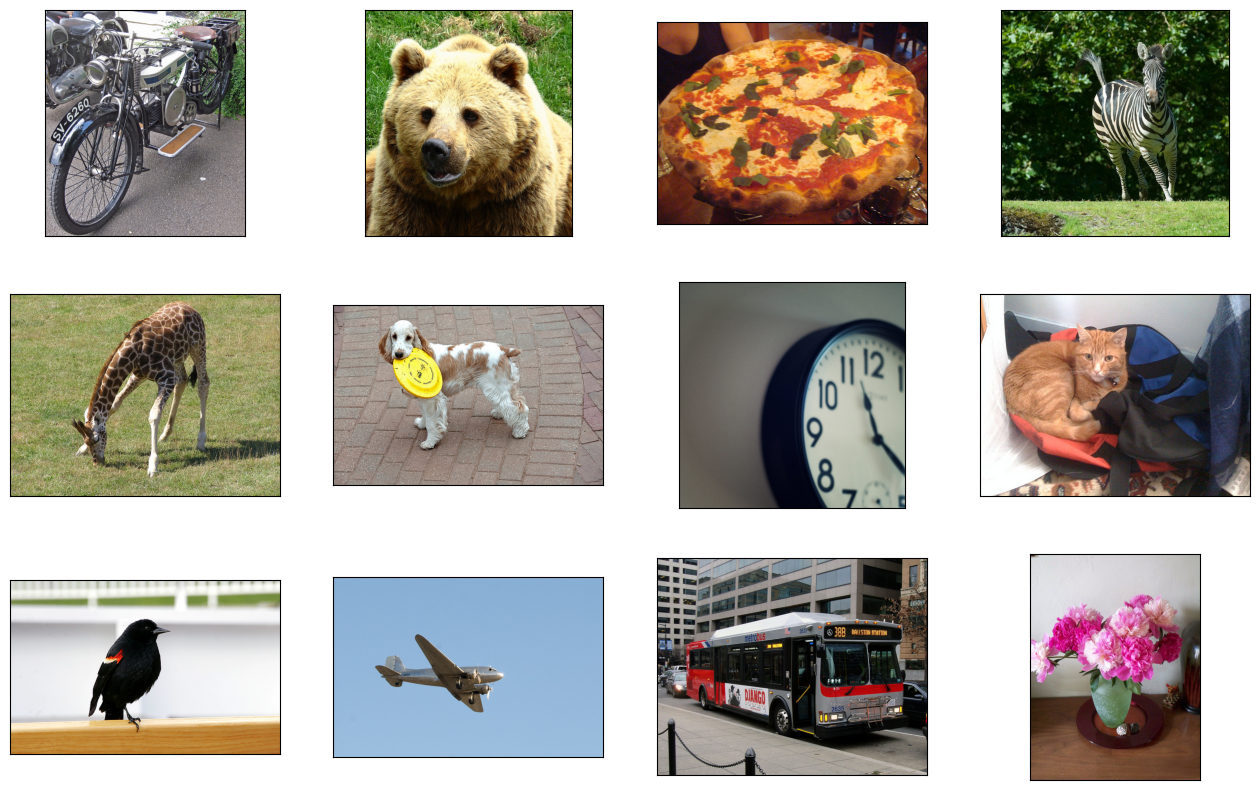

In [ ]:
# 이미지 시각화
plt.figure(figsize=(16,10))

for i, f in enumerate(img_file_list):
  plt.subplot(3,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = Image.open(dataset_dir+f)
  plt.imshow(img)
plt.show()

In [ ]:
# 이미지 전처리 시, 필요한 변환 정의
image_size = 224
img_transform = T.Compose([
    T.Resize(image_size), # 크기 변환
    T.CenterCrop(image_size), # 가운데 크롭
    T.ToTensor(), # 텐서 데이터 타입으로 변환
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize
])

In [ ]:
# 이미지 데이터 배치 만들기
images = []
for f in img_file_list:
  img = Image.open(dataset_dir+f)
  img = img_transform(img)
  images.append(np.asarray(img))
images = torch.tensor(images)
print('이미지 텐서 사이즈:', images.shape)

이미지 텐서 사이즈: torch.Size([12, 3, 224, 224])


#### 2.2 모델 추론하기


In [ ]:
# 모델 추론
model.eval()  # 모델을 추론모드로 변경
with torch.no_grad():
  logits = model(images.to(device))

In [ ]:
# 모델 아웃풋(logits) 보기
print('logits 텐서 사이즈:', logits.shape)
logits[0][:10]  # 10번째 클래스까지 logit 보기

logits 텐서 사이즈: torch.Size([12, 1000])


tensor([ 0.0402,  0.4120, -0.1379,  0.1557,  0.1488,  0.4559,  0.3112,  0.2219,
         0.3319, -0.2144], device='cuda:0')

### 2.3 성능 지표 계산하기

In [ ]:
# 예측 결과 보기
preds = torch.topk(logits, k=5).indices
# 레이블 이름 리스트
labels_list = [labels_map[str(i)] for i in range(len(labels_map.keys()))]

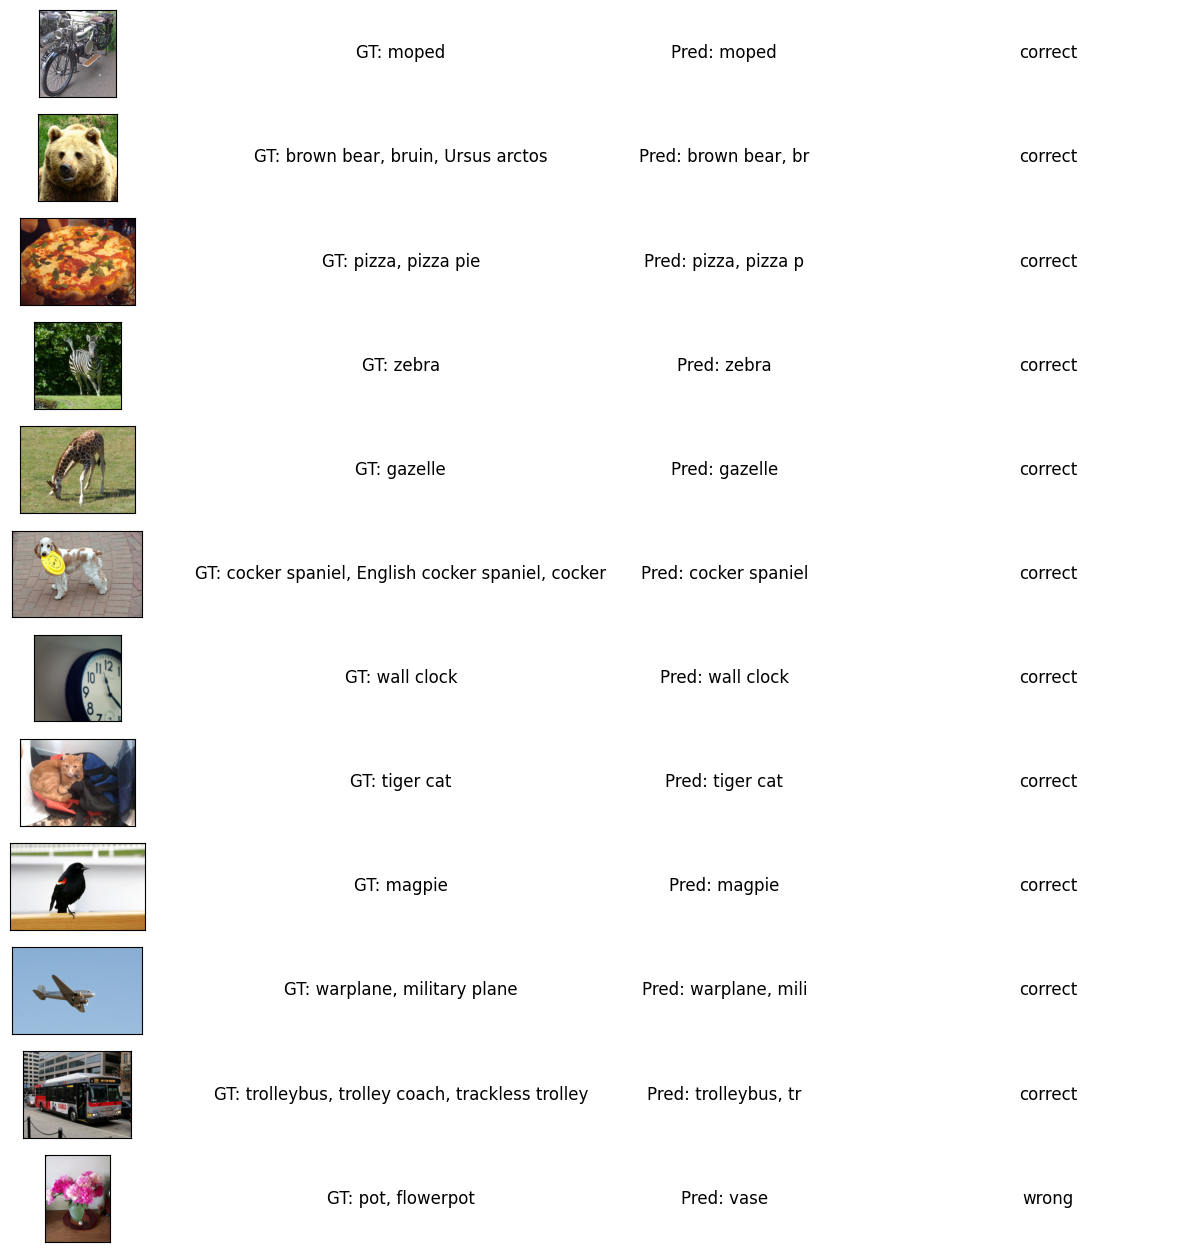

정확도 91.67%


In [ ]:
# 이미지 및 결과 시각화

# ground truth 레이블
ground_truth = [
    665, # 'moped'
    294, # 'brown bear, bruin, Ursus arctos
    963, # 'pizza, pizza pie
    340, # 'zebra
    353, # 'gazelle
    219, # 'cocker spaniel, English cocker spaniel, cocker
    892, # 'wall clock
    282, # 'tiger cat
    18,  # 'magpie
    895, # 'warplane, military plane
    874, # 'trolleybus, trolley coach, trackless trolley
    738 # 'pot, flowerpot
  ]

ground_truth_label = [
    'moped',
    'brown bear, bruin, Ursus arctos',
    'pizza, pizza pie',
    'zebra',
    'gazelle',
    'cocker spaniel, English cocker spaniel, cocker',
    'wall clock',
    'tiger cat',
    'magpie',
    'warplane, military plane',
    'trolleybus, trolley coach, trackless trolley',
    'pot, flowerpot'
]

# 예측 결과
prediction = preds[:, 0].cpu()
labels_preds = prediction.tolist()
label_preds = [labels_map[str(label)][:14] for label in labels_preds]

answer = []
if len(prediction) == len(ground_truth):
    for pred, gt in zip(prediction, ground_truth):
        if pred == gt:
            answer.append("correct")
        else:
            answer.append("wrong")


plt.figure(figsize=(16,16))

for i, (f, pred) in enumerate(zip(img_file_list, preds)):
    # 입력 이미지
    plt.subplot(12,4,i*4+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(dataset_dir+f)
    plt.imshow(img)
    # Ground Truth
    plt.subplot(12,4,i*4+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.text(0.5, 0.5, f"GT: {ground_truth_label[i]}", fontsize=12, ha='center', va='center')
    plt.axis('off')
    # Prediction
    plt.subplot(12,4,i*4+3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.text(0.5, 0.5, f"Pred: {label_preds[i]}", fontsize=12, ha='center', va='center')
    plt.axis('off')
    # 정답 여부
    plt.subplot(12,4,i*4+4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.text(0.5, 0.5, answer[i], fontsize=12, ha='center', va='center')
    plt.axis('off')
plt.show()

# 정확도(Accuracy) 계산
acc = prediction.eq(torch.tensor(ground_truth)).sum() / len(ground_truth)
print('정확도 {:.2f}%'.format(acc.item() * 100))

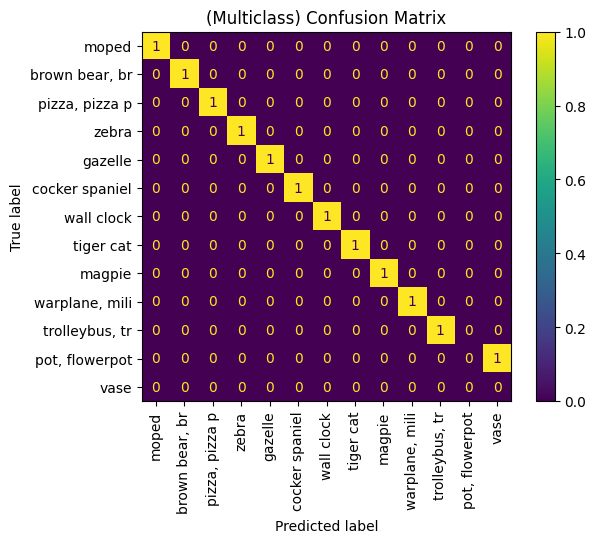

In [ ]:
# confusion matrix 시각화를 위해 레이블 순서를 정함
set_preds = set(prediction.tolist())
set_diff = list(set_preds.difference(ground_truth))
labels = ground_truth + set_diff
label_names = [labels_map[str(label)][:14] for label in labels]

# confusion matrix 계산
cf_mat = confusion_matrix(ground_truth, prediction, labels=labels)

# confusion matrix 시각화
ConfusionMatrixDisplay(cf_mat).plot()

plt.xticks(ticks=[*range(len(labels))], labels=label_names, rotation=90)
plt.yticks(ticks=[*range(len(labels))], labels=label_names)
plt.title('(Multiclass) Confusion Matrix')
plt.show()

## Reference
- EfficientNet-Pytorch GitHub Repository  [homepage](https://github.com/lukemelas/EfficientNet-PyTorch)
- EfficientNet in torchvision [link](https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/)

credits:
- 이미지: https://dogtime.com/dog-breeds/beagle, [MS COCO 데이터셋](https://cocodataset.org/#home)



## Required Package

> torch == 2.0.1